In [49]:
import pandas as pd
import numpy as np
import time as t
import scipy
from scipy.stats import skew
from scipy.stats import kurtosis
from numpy import sqrt
from statistics import mean
import warnings
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
warnings.filterwarnings('ignore')
from sklearn import preprocessing
import seaborn as sns
from scipy import stats 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import scipy.stats as stats
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from google.colab import files
uploaded = files.upload()
import io


Saving eating_1_heart.csv to eating_1_heart (3).csv
Saving eating_1_wrist.csv to eating_1_wrist (3).csv
Saving eating_2_heart_swissroll.csv to eating_2_heart_swissroll (3).csv
Saving eating_2_wrist_swissroll.csv to eating_2_wrist_swissroll (3).csv
Saving eating_3_second_swissroll_heart.csv to eating_3_second_swissroll_heart (3).csv
Saving eating_3_second_swissroll_wrist.csv to eating_3_second_swissroll_wrist (3).csv
Saving eating_4_heart.csv to eating_4_heart (3).csv
Saving eating_4_wrist.csv to eating_4_wrist (3).csv
Saving eating_5_dinner_heart.csv to eating_5_dinner_heart (3).csv
Saving eating_5_dinner_wrist.csv to eating_5_dinner_wrist (3).csv
Saving eating_6_netflix+dinner_heart.csv to eating_6_netflix+dinner_heart (3).csv
Saving eating_6_netflix+dinner_wrist.csv to eating_6_netflix+dinner_wrist (3).csv
Saving eating_yogurt_heart.csv to eating_yogurt_heart (3).csv
Saving eating_yogurt_wrist.csv to eating_yogurt_wrist (3).csv
Saving heart_dinner.csv to heart_dinner (3).csv
Saving n

In [54]:
#defining relative position for the two sensors where data1 o data_a corresponds to data from sensors near to heart level which is our reference point
#also the data2 or data_b corresponds to data from sensor on wrist
def relative_position_extraction(data1,data2):
  #to check if both the samples hae equal number of rows, if they are unequal then we trim the dataset and make both of them have equal length
  # as of the smallest dataset
  if(len(data1)<len(data2)):
   data2 = data2[0:len(data1)]
  else:
    data1 = data1[0:len(data2)]

  #if the data1 is not reliable(warning generated by the sensor in the column Estimation Warning)
  # then we drop those rows for both the files(i.e.  for wrist and heart)
  data_heart = data1[data1['Estimation_Warning'] == 'The accuracy of the estimations is reliable'].reset_index(drop=True)#drop not reliable data 
  data_heart = data1[data2['Estimation_Warning'] == 'The accuracy of the estimations is reliable'].reset_index(drop=True)#drop not reliable data 

  data_wrist = data2[data2['Estimation_Warning'] == 'The accuracy of the estimations is reliable'].reset_index(drop=True)#drop not reliable data    
  data_wrist = data2[data1['Estimation_Warning'] == 'The accuracy of the estimations is reliable'].reset_index(drop=True)#drop not reliable data    
  
  col=['W','X','Y','Z','T']
  relative_position1= pd.DataFrame(data_heart.iloc[:,[0,1,2,3,-2]],columns=col)
  #set the counter for the datas from the Timestamp column from one sensor and using it for the other sensor as well. We convert the loop counter to linear counter
  #the counter starts from zero and goes to infinity
  diff = np.diff(data_heart['Timestamp'])
  relative_position1['T'] = np.zeros(len(data_heart['Timestamp']))
  for i in range(1,len(data_heart['Timestamp'])):
    if diff[i-1] >= 0:
      relative_position1['T'][i] = relative_position1['T'][i-1] + diff[i-1]
    elif diff[i-1]<0:
      relative_position1['T'][i] = relative_position1['T'][i-1] + (256-data_heart['Timestamp'][i-1] -diff[i-1] )
  
  i = 0
  print(relative_position1['T'],data_heart['Timestamp'],"relative_time")
  while(i<len(data_heart)):
                  #time_duration = (data['Timestamp'][i]-data['Timestamp'][i-1])
                  relative_position1['X'][i] = (data_heart['X'][i]-data_wrist['X'][i])
                  relative_position1['Y'][i] = (data_heart['Y'][i]-data_wrist['Y'][i])
                  relative_position1['Z'][i] = (data_heart['Z'][i]-data_wrist['Z'][i])
                  relative_position1['W'][i] = (data_heart['W'][i]-data_wrist['W'][i])
                  relative_position = relative_position1.iloc[:,:]
                  i=i+1
  features=pd.concat([relative_position.iloc[:,:]],axis=1)
  features.columns = ['w_relative','x_relative','y_relative','z_relative','t_relative']                
  return features

In [3]:
#function to assign labels corresponding to the manipulated data if the data is from eating sample that is 1 or from the non-eating sample that is 0
def labeling(arr,label):
    arr1={}
    for i in range(len(arr)):
        if label[i]==0:
            lab=np.zeros(len(arr[i]))
            lab= pd.DataFrame(lab,columns={"labels"})
            arr1[i]=pd.concat([arr[i],lab],axis=1)
        else:
            lab=np.ones(len(arr[i]))
            lab= pd.DataFrame(lab,columns={"labels"})
            arr1[i]=pd.concat([arr[i],lab],axis=1)
    return arr1        

In [55]:
#function to extract the features; first we calculate the relative position from both the sensors and then extract our features
def extract(arr):
    out1={}
    for i in range(0,len(arr)-1,2):
        y=relative_position_extraction(arr[i],arr[i+1])   
        out1[i/2]=feature_extraction(y)     
    return out1    

In [56]:
def clean_data(arr,name):
    out1={}
    v=arr
    for i in range(len(arr)):
        v[i]=arr[i].ewm(com=0.8).mean()
        plot_box_plot(v[i],name[i])
        out1[i]=replace_outlier_bymedian(v[i],name[i])
        plot_box_plot(v[i],name[i])
    return out1    

In [57]:
def replace_outlier_bymedian(df_in,name):
    Q1 = df_in.iloc[:,:-1].quantile(0.25)
    Q3 = df_in.iloc[:,:-1].quantile(0.75)
    IQR = Q3 - Q1
    fence_low  = Q1-1.7*IQR
    fence_high = Q3+1.7*IQR
    col=['W','X','Y','Z']
    col1=df_in.iloc[:,:-2].columns
    clean_data=df_in
    print("inside replace outlier")
    for i in col1:
        index=np.where( (df_in[i]<fence_low[i]) | (df_in[i]>fence_high[i]))[0]
        print(index,"\n")
        index1=np.where(~(df_in[i]<fence_low[i]) | (df_in[i]>fence_high[i]))[0]
        count=len(index)
        median=np.median(df_in[i][~( (df_in[i]<fence_low[i]) | (df_in[i]>fence_high[i]))])
        clean_data[i][index]=median 
        Q1 = df_in[i].quantile(0.25)
        Q3 = df_in[i].quantile(0.75)
        IQR = Q3 - Q1
        fence_low_new  = Q1-1.7*IQR
        fence_high_new = Q3+1.7*IQR
        count_new=len(np.where( (df_in[i]<fence_low_new) | (df_in[i]>fence_high_new))[0])
        print("\n number of outlier in file "+name +" in axis "+str(i)+" berfore the replacing process is",count," and its percentage is",count/len(df_in[i])*100,"\nand after replacing by the median the number of outliers is",count_new," and its percentage is",count_new/len(df_in[i])*100)
    return clean_data

In [7]:
def plot_box_plot(df_in,name):
    fig = plt.figure(figsize =(10, 7))
    col1=df_in.iloc[:,:-1].columns
    plt.title("name")
    ax = fig.add_axes([0, 0, 1, 1])
    bp = ax.boxplot(df_in.iloc[:,:-1])
    ax.set_xticklabels(col1)
    plt.show() 

In [153]:
#we have 14.9831 ticks of the sensors is equivalent to 1s 
#we need to make frames with 7s i.e., 104.8817 ticks with 50% percent overlapping  

def feature_extraction(df):
    print("inside feature calculation")
    tick_7s= 200
    
    start=0 
    end=1 # dependat on rate
    i=0
    diff=0
    col=['w_relative','x_relative','y_relative','z_relative']
    mean1= pd.DataFrame(columns=col)
    var1= pd.DataFrame(columns=col)
    skewness1= pd.DataFrame(columns=col)
    rms1= pd.DataFrame(columns=col)
    kurtosis1= pd.DataFrame(columns=col)
    time=pd.DataFrame(columns={'duration'})
    print(df.iloc[:,:4])
    print(mean1)
    i=0
    while(end<len(df)-1):
        diff=0
        while(diff<=tick_7s):
            diff=(df['t_relative'][end]- df['t_relative'][start])
#            if diff<0:
 #               diff=diff+256
            if(end<len(df)-1):
                end=end+1
            else:
                end=len(df)-1
                break;
        mean1 = mean1.append(np.mean(df.iloc[start:end,0:4]),ignore_index=True)
        var1=var1.append(np.var(df.iloc[start:end,0:4]),ignore_index=True)
        rms1=rms1.append(sqrt(np.mean((df.iloc[start:end,0:4])**2)),ignore_index=True)
        ser1 = pd.Series(df.iloc[start:end,0:4].skew())
        skewness1=skewness1.append(ser1,ignore_index=True)
        ser2 = pd.Series(kurtosis(df.iloc[start:end,0:4], axis=0, bias=False), index=col)
        kurtosis1=kurtosis1.append(ser2,ignore_index=True)
        ser3=pd.Series(diff, index=['duration'])
        time=time.append(ser3,ignore_index=True)
        start=start+int(0.5*(end-start))# for overlapping  by 50%
        i=i+1

    features=pd.concat([mean1,var1,rms1,skewness1,kurtosis1,time],axis=1)
    features.columns = [ 'w_mean','x_mean','y_mean','z_mean','w_var', 'x_var','y_var', 'z_var',
                        'w_rms', 'x_rms','y_rms', 'z_rms',
                        'w_skew', 'x_skew','y_skew', 'z_skew',
                        'w_kurtosis', 'x_kurtosis','y_kurtosis','z_kurtosis','duration']
    return features

In [111]:
def visulaize_data(x,y):
    col=["w_mean",'x_mean','y_mean','z_mean']
    col1=["w_var",'x_var','y_var','z_var']
    for (i,j) in zip(col,col1): 
        fig1 = plt.figure()
        plt.scatter(x[i][y==1], x[y==1][j], label='Eating', c='red')
        plt.scatter(x[i][y==0], x[y==0][j], label='Not eating', c='blue')
        plt.legend()
        plt.xlabel(str(i))
        plt.ylabel(str(j))
    col=["w_rms",'x_rms','y_rms','z_rms']
    col1=["w_skew",'x_skew','y_skew','z_skew']

 

In [112]:
sensor_data1=pd.read_csv(r"eating_1_heart.csv")
sensor_data2=pd.read_csv(r"eating_1_wrist.csv")
sensor_data3=pd.read_csv(r"eating_2_heart_swissroll.csv")
sensor_data4=pd.read_csv(r"eating_2_wrist_swissroll.csv")
sensor_data5=pd.read_csv(r"eating_3_second_swissroll_heart.csv")
sensor_data6=pd.read_csv(r"eating_3_second_swissroll_wrist.csv")
sensor_data7=pd.read_csv(r"eating_4_heart.csv")
sensor_data8=pd.read_csv(r"eating_4_wrist.csv")
sensor_data9=pd.read_csv(r"eating_5_dinner_heart.csv")
sensor_data10=pd.read_csv(r"eating_5_dinner_wrist.csv")
sensor_data11=pd.read_csv(r"eating_6_netflix+dinner_heart.csv")
sensor_data12=pd.read_csv(r"eating_6_netflix+dinner_wrist.csv")
sensor_data13=pd.read_csv(r"eating_yogurt_heart.csv")
sensor_data14=pd.read_csv(r"eating_yogurt_wrist.csv")
sensor_data15=pd.read_csv(r"non_eating_1_heart_walking.csv")
sensor_data16=pd.read_csv(r"non_eating_1_wrist_walking.csv")
sensor_data17=pd.read_csv(r"non_eating_2_heart_laptop.csv")
sensor_data18=pd.read_csv(r"non_eating_2_wrist_laptop.csv")
sensor_data19=pd.read_csv(r"heart_dinner.csv")
sensor_data20=pd.read_csv(r"wrist_dinner.csv")
sensor_data21=pd.read_csv(r"wiping_non_eating_heart_1.csv")
sensor_data22=pd.read_csv(r"wiping_non_eating_wrist_1.csv")
sensor_data23=pd.read_csv(r"wiping_non_eating_heart_2.csv")
sensor_data24=pd.read_csv(r"wiping_non_eating_wrist_2.csv")

In [113]:
arr=[sensor_data1,sensor_data2,sensor_data3,sensor_data4,sensor_data5,sensor_data6,sensor_data7,sensor_data8,sensor_data9,sensor_data10,sensor_data11,sensor_data12,sensor_data13,sensor_data14,sensor_data15,sensor_data16,sensor_data17,sensor_data18,sensor_data19,sensor_data20,sensor_data21,sensor_data22,sensor_data23,sensor_data24]
print(len(arr))
name=["eating_1_heart","eating_1_wrist","eating_2_heart_swissroll","eating_2_wrist_swissroll","eating_3_second_swissroll_heart","eating_3_second_swissroll_wrist","eating_4_heart","eating_4_wrist","eating_5_dinner_heart","eating_5_dinner_wrist","eating_6_netflix+dinner_heart","eating_6_netflix+dinner_wrist","eating_yogurt_heart","eating_yogurt_wrist","non_eating_1_heart_walking","non_eating_1_wrist_walking","non_eating_2_heart_laptop","non_eating_2_wrist_laptop","heart_dinner.csv","wrist_dinner.csv","cuddle_non_eating_heart.csv","cuddle_non_eating_wrist.csv","wiping_non_eating_heart_1.csv","wiping_non_eating_wrist_1.csv","wiping_non_eating_heart_2.csv","wiping_non_eating_wrist_2.csv"]


24


In [154]:
fe1=extract(arr)

0          0.000000
1          0.078007
2          0.156015
3          1.134040
4          2.034054
           ...     
7441    6553.967257
7442    6554.789266
7443    6555.767292
7444    6555.845301
7445    6556.001321
Name: T, Length: 7446, dtype: float64 0       49.068114
1       49.146121
2       49.224129
3       50.202154
4       51.102168
          ...    
7441    25.203099
7442    26.025108
7443    27.003134
7444    27.081143
7445    27.237163
Name: Timestamp, Length: 7446, dtype: float64 relative_time
inside feature calculation
      w_relative  x_relative  y_relative  z_relative
0       0.223944   -0.169609   -0.071359    0.777130
1       0.223497   -0.169359   -0.071742    0.777358
2       0.223460   -0.169822   -0.072182    0.777273
3       0.223186   -0.169562   -0.072218    0.777574
4       0.222876   -0.169575   -0.072394    0.777538
...          ...         ...         ...         ...
7441    0.089086   -0.074041    0.102307    0.119195
7442    0.091996   -0.075828    0

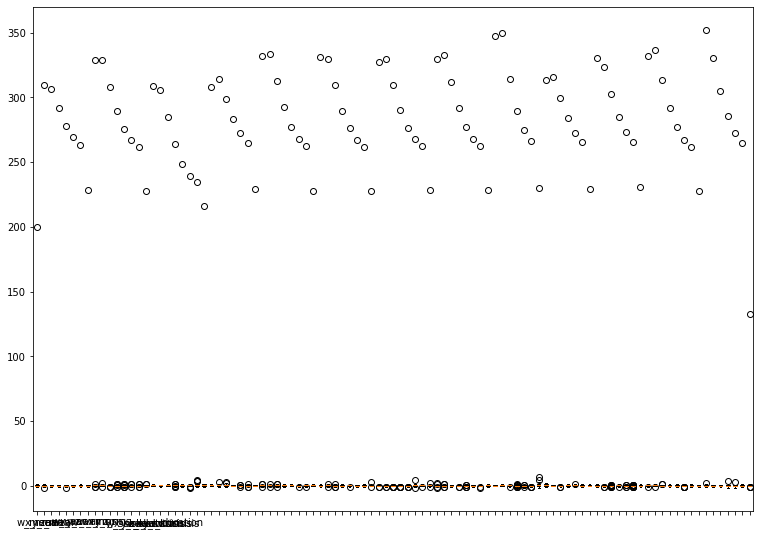

inside replace outlier
[95 96 97] 


 number of outlier in file eating1 in axis w_mean berfore the replacing process is 3  and its percentage is 3.0303030303030303 
and after replacing by the median the number of outliers is 0  and its percentage is 0.0
[96 97] 


 number of outlier in file eating1 in axis x_mean berfore the replacing process is 2  and its percentage is 2.0202020202020203 
and after replacing by the median the number of outliers is 1  and its percentage is 1.0101010101010102
[] 


 number of outlier in file eating1 in axis y_mean berfore the replacing process is 0  and its percentage is 0.0 
and after replacing by the median the number of outliers is 0  and its percentage is 0.0
[1 2 3 4 5 6 7] 


 number of outlier in file eating1 in axis z_mean berfore the replacing process is 7  and its percentage is 7.07070707070707 
and after replacing by the median the number of outliers is 0  and its percentage is 0.0
[39] 


 number of outlier in file eating1 in axis w_var berf

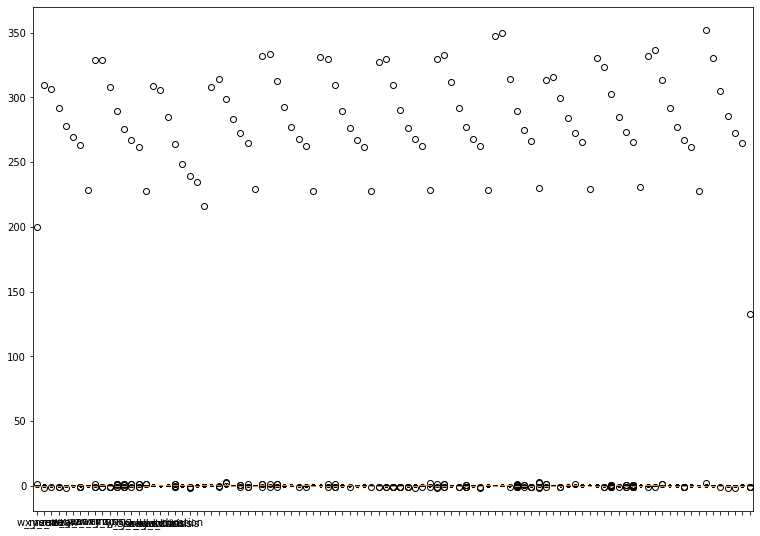

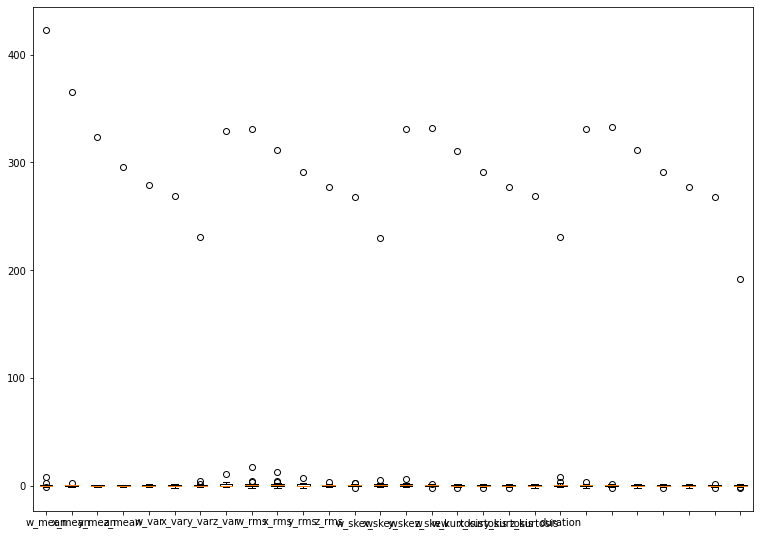

inside replace outlier
[ 0  1  2  3 10] 


 number of outlier in file eating2 in axis w_mean berfore the replacing process is 5  and its percentage is 17.857142857142858 
and after replacing by the median the number of outliers is 8  and its percentage is 28.57142857142857
[0 1 2] 


 number of outlier in file eating2 in axis x_mean berfore the replacing process is 3  and its percentage is 10.714285714285714 
and after replacing by the median the number of outliers is 1  and its percentage is 3.571428571428571
[] 


 number of outlier in file eating2 in axis y_mean berfore the replacing process is 0  and its percentage is 0.0 
and after replacing by the median the number of outliers is 0  and its percentage is 0.0
[0 1] 


 number of outlier in file eating2 in axis z_mean berfore the replacing process is 2  and its percentage is 7.142857142857142 
and after replacing by the median the number of outliers is 0  and its percentage is 0.0
[] 


 number of outlier in file eating2 in axis w_

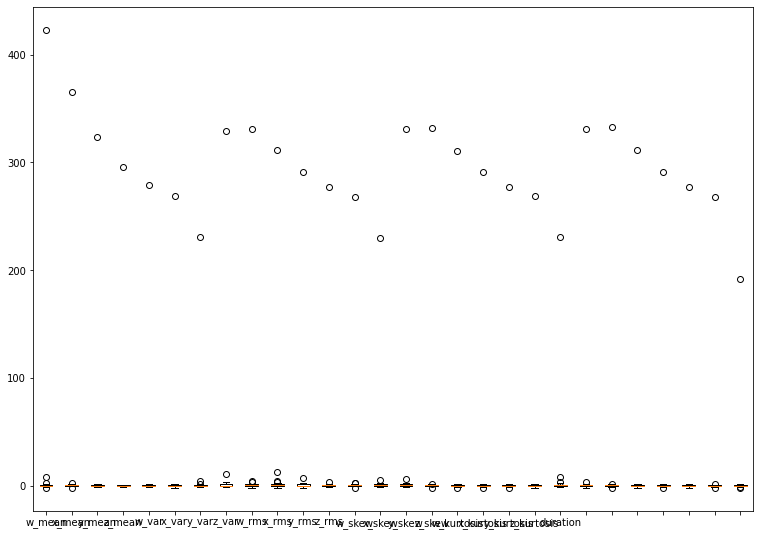

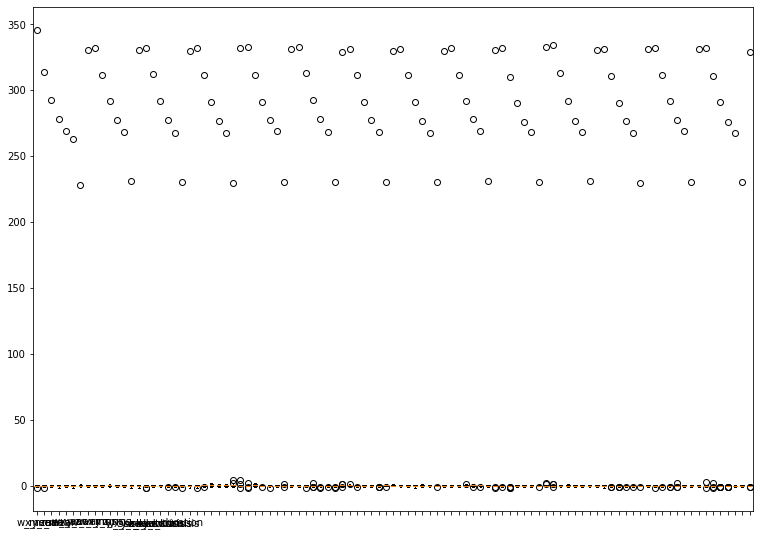

inside replace outlier
[24 25 26 96] 


 number of outlier in file swissroll in axis w_mean berfore the replacing process is 4  and its percentage is 4.040404040404041 
and after replacing by the median the number of outliers is 1  and its percentage is 1.0101010101010102
[] 


 number of outlier in file swissroll in axis x_mean berfore the replacing process is 0  and its percentage is 0.0 
and after replacing by the median the number of outliers is 0  and its percentage is 0.0
[] 


 number of outlier in file swissroll in axis y_mean berfore the replacing process is 0  and its percentage is 0.0 
and after replacing by the median the number of outliers is 0  and its percentage is 0.0
[10 11 12 25 26] 


 number of outlier in file swissroll in axis z_mean berfore the replacing process is 5  and its percentage is 5.05050505050505 
and after replacing by the median the number of outliers is 2  and its percentage is 2.0202020202020203
[15 50] 


 number of outlier in file swissroll in axis

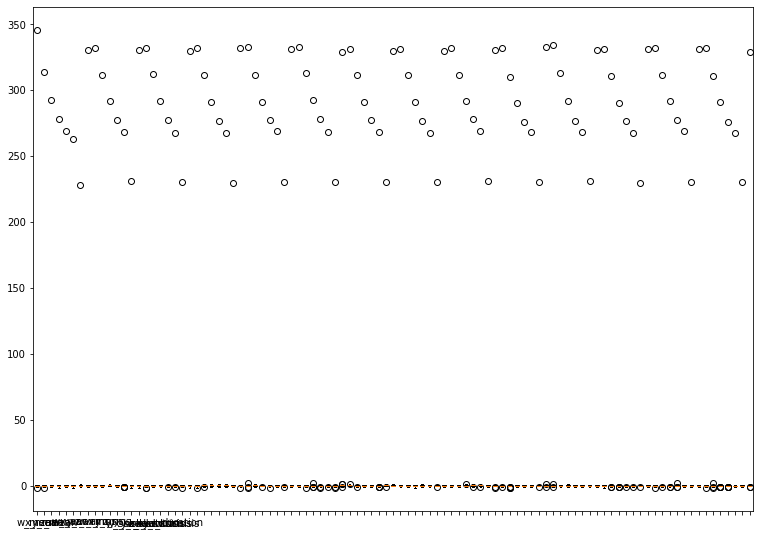

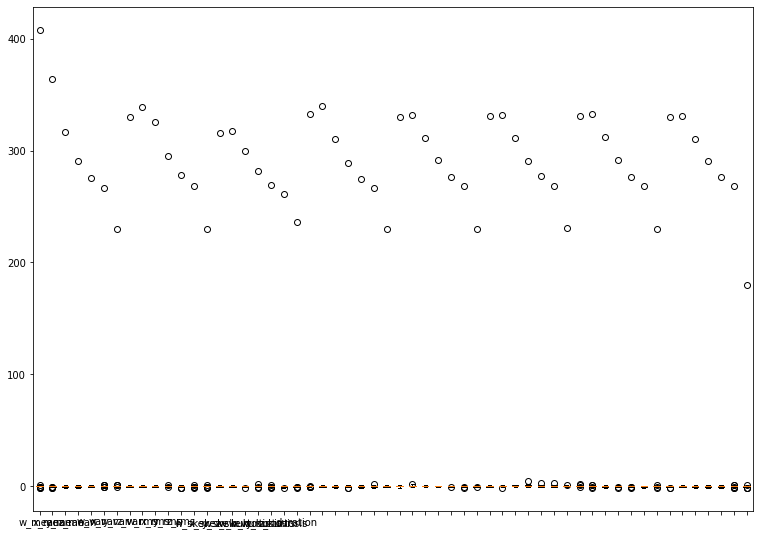

inside replace outlier
[] 


 number of outlier in file secondswissroll in axis w_mean berfore the replacing process is 0  and its percentage is 0.0 
and after replacing by the median the number of outliers is 0  and its percentage is 0.0
[] 


 number of outlier in file secondswissroll in axis x_mean berfore the replacing process is 0  and its percentage is 0.0 
and after replacing by the median the number of outliers is 0  and its percentage is 0.0
[] 


 number of outlier in file secondswissroll in axis y_mean berfore the replacing process is 0  and its percentage is 0.0 
and after replacing by the median the number of outliers is 0  and its percentage is 0.0
[25 26 37 38 39] 


 number of outlier in file secondswissroll in axis z_mean berfore the replacing process is 5  and its percentage is 8.928571428571429 
and after replacing by the median the number of outliers is 3  and its percentage is 5.357142857142857
[41 42] 


 number of outlier in file secondswissroll in axis w_var ber

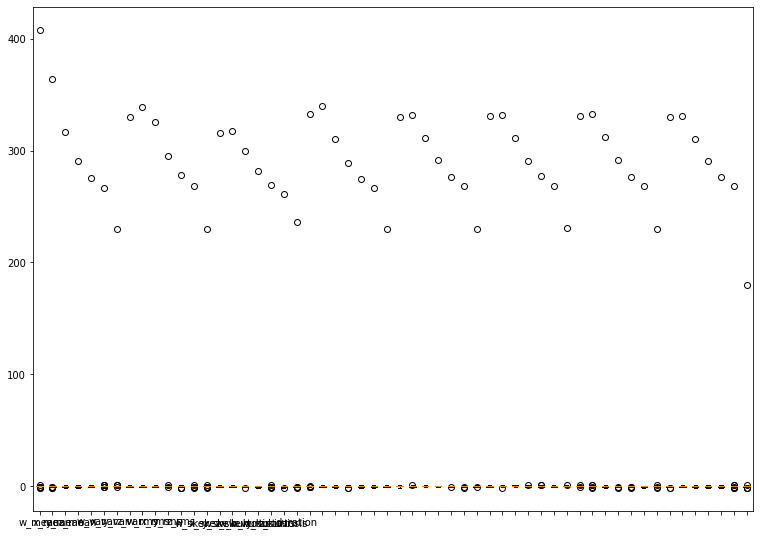

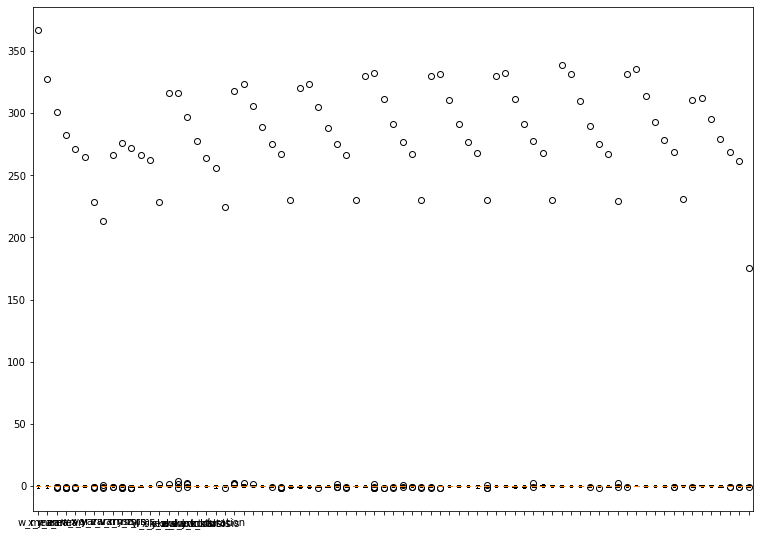

inside replace outlier
[53 54] 


 number of outlier in file dinner in axis w_mean berfore the replacing process is 2  and its percentage is 2.5974025974025974 
and after replacing by the median the number of outliers is 0  and its percentage is 0.0
[3] 


 number of outlier in file dinner in axis x_mean berfore the replacing process is 1  and its percentage is 1.2987012987012987 
and after replacing by the median the number of outliers is 0  and its percentage is 0.0
[] 


 number of outlier in file dinner in axis y_mean berfore the replacing process is 0  and its percentage is 0.0 
and after replacing by the median the number of outliers is 0  and its percentage is 0.0
[] 


 number of outlier in file dinner in axis z_mean berfore the replacing process is 0  and its percentage is 0.0 
and after replacing by the median the number of outliers is 0  and its percentage is 0.0
[62 70 71] 


 number of outlier in file dinner in axis w_var berfore the replacing process is 3  and its percent

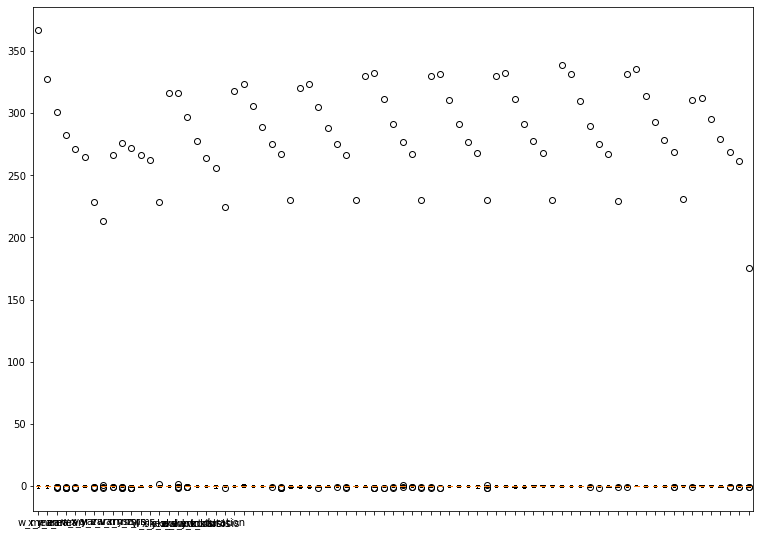

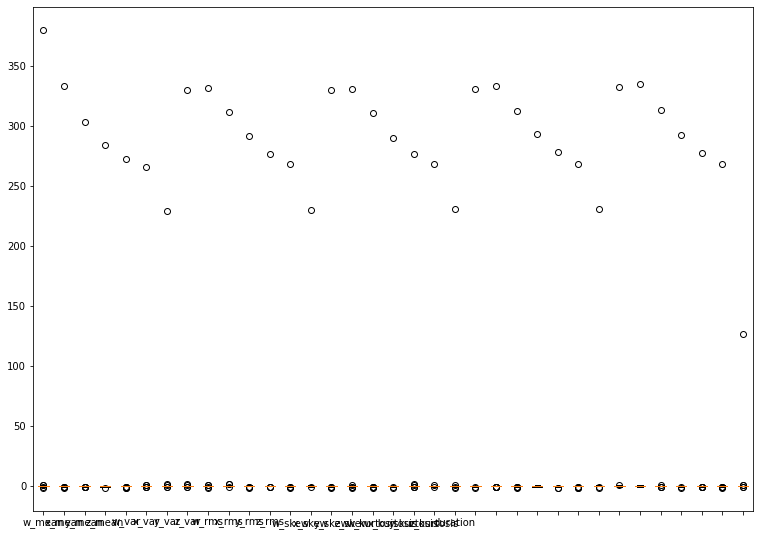

inside replace outlier
[] 


 number of outlier in file netflix+dinner in axis w_mean berfore the replacing process is 0  and its percentage is 0.0 
and after replacing by the median the number of outliers is 0  and its percentage is 0.0
[] 


 number of outlier in file netflix+dinner in axis x_mean berfore the replacing process is 0  and its percentage is 0.0 
and after replacing by the median the number of outliers is 0  and its percentage is 0.0
[] 


 number of outlier in file netflix+dinner in axis y_mean berfore the replacing process is 0  and its percentage is 0.0 
and after replacing by the median the number of outliers is 0  and its percentage is 0.0
[] 


 number of outlier in file netflix+dinner in axis z_mean berfore the replacing process is 0  and its percentage is 0.0 
and after replacing by the median the number of outliers is 0  and its percentage is 0.0
[6 7 8] 


 number of outlier in file netflix+dinner in axis w_var berfore the replacing process is 3  and its percen

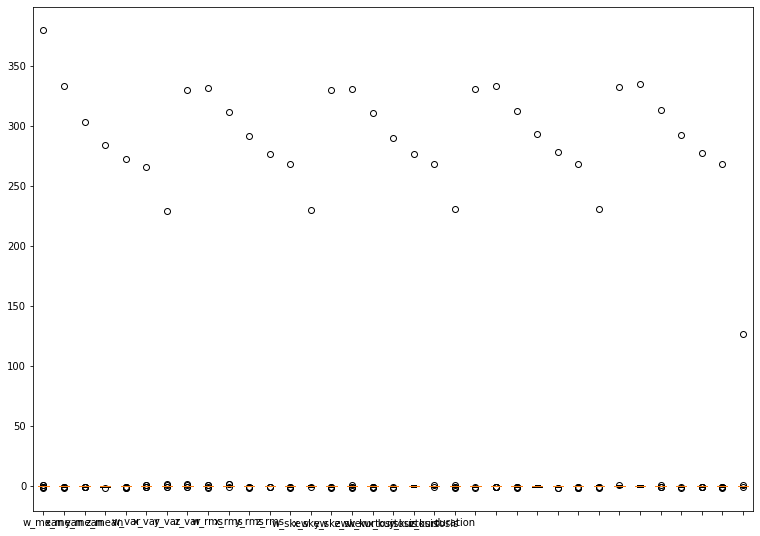

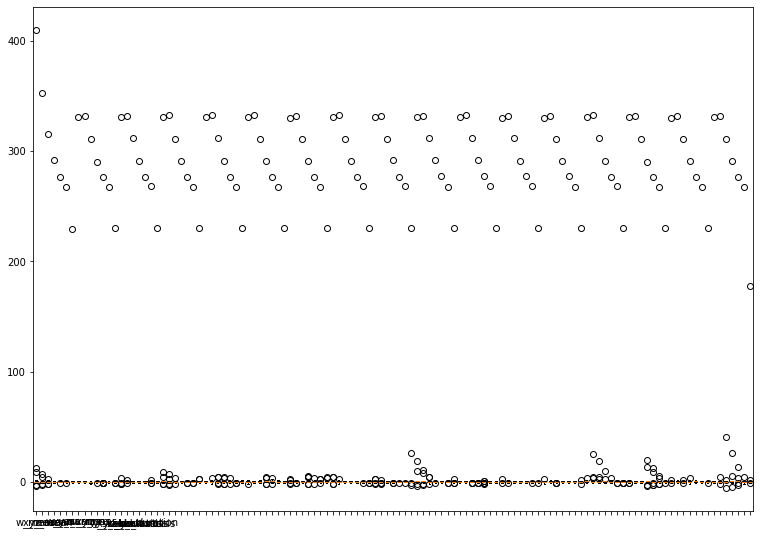

inside replace outlier
[ 5 26 68] 


 number of outlier in file eating_yogurt in axis w_mean berfore the replacing process is 3  and its percentage is 2.5210084033613445 
and after replacing by the median the number of outliers is 1  and its percentage is 0.8403361344537815
[] 


 number of outlier in file eating_yogurt in axis x_mean berfore the replacing process is 0  and its percentage is 0.0 
and after replacing by the median the number of outliers is 0  and its percentage is 0.0
[] 


 number of outlier in file eating_yogurt in axis y_mean berfore the replacing process is 0  and its percentage is 0.0 
and after replacing by the median the number of outliers is 0  and its percentage is 0.0
[ 83  84  91  92  93  94  95  96 104 105 118] 


 number of outlier in file eating_yogurt in axis z_mean berfore the replacing process is 11  and its percentage is 9.243697478991598 
and after replacing by the median the number of outliers is 3  and its percentage is 2.5210084033613445
[44] 


 n

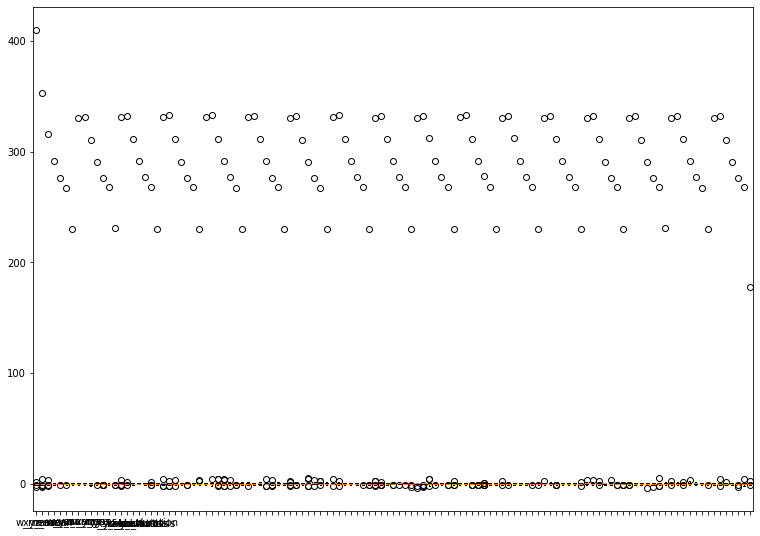

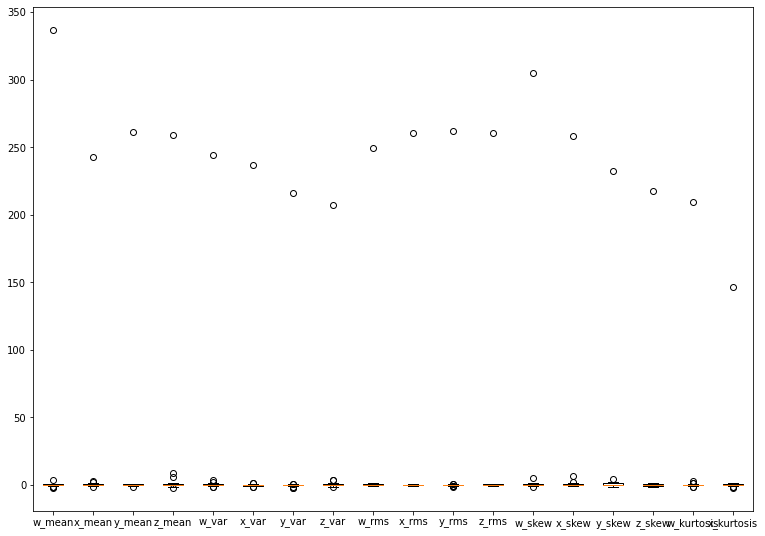

inside replace outlier
[] 


 number of outlier in file walking in axis w_mean berfore the replacing process is 0  and its percentage is 0.0 
and after replacing by the median the number of outliers is 0  and its percentage is 0.0
[0 1 2] 


 number of outlier in file walking in axis x_mean berfore the replacing process is 3  and its percentage is 16.666666666666664 
and after replacing by the median the number of outliers is 1  and its percentage is 5.555555555555555
[] 


 number of outlier in file walking in axis y_mean berfore the replacing process is 0  and its percentage is 0.0 
and after replacing by the median the number of outliers is 0  and its percentage is 0.0
[0 1 2] 


 number of outlier in file walking in axis z_mean berfore the replacing process is 3  and its percentage is 16.666666666666664 
and after replacing by the median the number of outliers is 0  and its percentage is 0.0
[0] 


 number of outlier in file walking in axis w_var berfore the replacing process is 1 

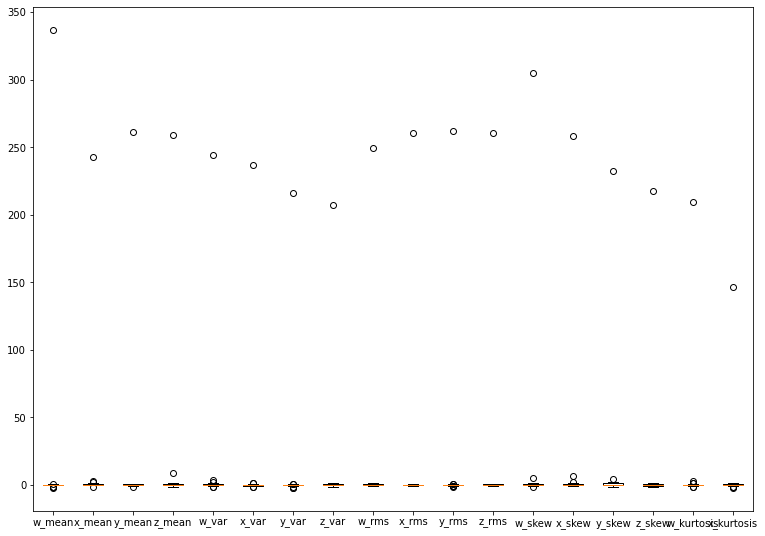

In [162]:
label=[1,1,1,1,1,1,1,0,0,1,0,0]
c1=labeling(fe1,label)
train=[c1[0],c1[1],c1[2],c1[3],c1[6],c1[8],c1[9],c1[11]]
test=[c1[4],c1[5],c1[10],c1[7]]
name=["eating1","eating2","swissroll","secondswissroll","dinner","netflix+dinner","eating_yogurt","walking","laptop_use","dinner_15feb","wiping_non_eating_1","wiping_non_eating_2"]
cleaned_data=clean_data(train,name)
features=pd.concat( cleaned_data ,axis=0,ignore_index=True)
test=pd.concat(test,axis=0,ignore_index=True)


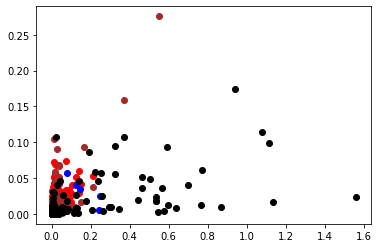

In [163]:
x=features
y=features['labels']
c=test
y1=test['labels']
plt.scatter(x["z_var"][y==1], x["y_var"][y==1],   label='Eating', c='red')
plt.scatter(x["z_var"][y==0], x["y_var"][y==0],   label='Not eating', c='blue')
plt.scatter(c["z_var"][y1==1], c["y_var"][y1==1], label='Eating', c='brown')
plt.scatter(c["z_var"][y1==0], c["y_var"][y1==0], label='Not eating', c='black')

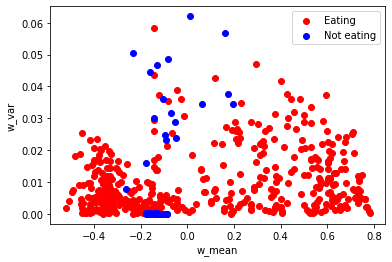

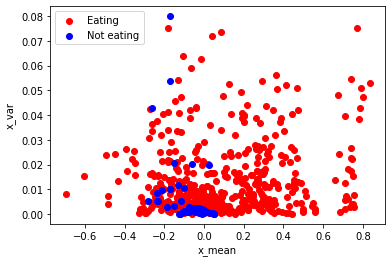

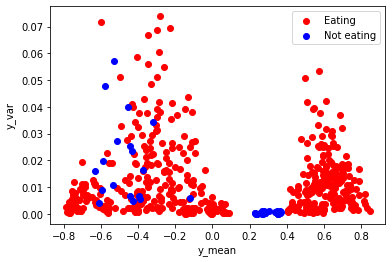

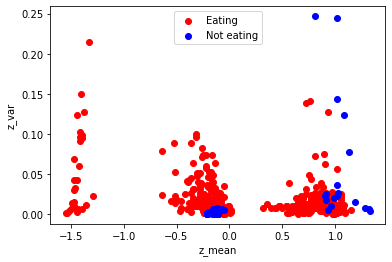

In [164]:
y_train=features['labels']
visulaize_data(features,y_train)

In [165]:
# assign test data size 25%
features
X=features.iloc[:,:-11]
X_train=features.iloc[:,:-6]
y_train=features['labels']
X_test=test.iloc[:,:-6]
y_test=test['labels']
print(test.iloc[:,:-6])
features.iloc[:,:-6]


       w_mean    x_mean    y_mean    z_mean     w_var     x_var     y_var  \
0   -0.176583  0.088197  0.721286 -0.158489  0.007334  0.025072  0.010775   
1   -0.131035  0.056050  0.725371 -0.118598  0.007364  0.015699  0.005226   
2   -0.081474  0.066579  0.707206 -0.040516  0.004071  0.006786  0.002757   
3   -0.036956  0.068758  0.702343  0.005783  0.002015  0.002915  0.001892   
4   -0.065974  0.059935  0.686490 -0.019894  0.000422  0.002143  0.001927   
..        ...       ...       ...       ...       ...       ...       ...   
333 -0.398353 -0.605339 -0.518389  1.194100  0.050454  0.008966  0.014013   
334 -0.189083 -0.688423 -0.409046  1.217038  0.019206  0.000674  0.006827   
335 -0.065943 -0.703717 -0.331719  1.167110  0.001558  0.000134  0.000837   
336  0.062913  0.007423 -0.166335  0.002465  0.121061  0.177918  0.052184   
337 -0.092976  0.013379 -0.191397 -0.034604  0.099217  0.102217  0.055551   

        z_var     w_rms     x_rms     y_rms     z_rms    w_skew    x_skew  

,w_mean,x_mean,y_mean,z_mean,w_var,x_var,y_var,z_var,w_rms,x_rms,y_rms,z_rms,w_skew,x_skew,y_skew,z_skew
0,0.322097,-0.070913,-0.323294,0.396654,0.019020,0.038930,0.002389,0.007792,0.350379,0.209664,0.438506,0.838174,-0.253712,0.519810,-0.865023,-0.938349
1,0.351845,-0.068397,-0.453084,0.771824,0.026850,0.042071,0.002389,0.007792,0.387833,0.216179,0.534944,0.807715,-0.730349,0.351205,-0.633625,-0.059217
2,0.393554,-0.168953,-0.593265,0.771824,0.011231,0.021405,0.002389,0.007792,0.408496,0.236976,0.649646,0.798092,0.043300,0.164559,-0.486087,0.384629
3,0.400726,-0.165731,-0.522869,0.771824,0.004763,0.010885,0.002389,0.007792,0.407061,0.199943,0.548335,0.810901,0.404961,-0.030049,-0.517642,-0.041623
4,0.402995,-0.134843,-0.468125,0.771824,0.002071,0.004964,0.012732,0.043055,0.405749,0.150753,0.479425,0.803774,0.010775,0.078181,-0.221460,-0.146761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,0.063905,-0.116326,-0.441088,1.180813,0.034460,0.005082,0.006561,0.014926,0.275332,0.138458,0.448214,1.187371,-0.430009,1.987223,-0.142917,-0.427682
527,0.175184,-0.101368,-0.390313,1.280927,0.037543,0.010612,0.005737,0.006819,0.306471,0.145842,0.397473,1.283909,-1.246981,2.015147,-0.850966,-0.602210
528,0.160721,-0.058557,-0.393339,1.327196,0.056715,0.020022,0.006635,0.003223,0.306810,0.158014,0.401623,1.328592,-0.873675,1.252187,-0.480387,-0.606522
529,0.013656,0.027688,-0.425600,1.320744,0.062031,0.019953,0.004770,0.006119,0.290619,0.165235,0.431291,1.323143,-0.050231,-0.093644,0.033399,-1.637450


In [166]:
#considring each prediction is almost 7 second we will search for 2 minutes
#120s/7s=17,17 so we will work on 12 frame so if we detect more than 60% eating in the frame it will consider eating 12 frame==1 
def eating_decision(y_pred):
    count=0
    i=0
    t=17
    step=15/t  # for overlapping
    eating=np.zeros(int(len(y_pred)/(step*t))+1)
    e=0
    cur=0
    while(cur<len(y_pred)-1):
        eating[e]=0
        count=0
        for j in range(t):
            if(cur<len(y_pred)-1):
                if(y_pred[cur]==1):
                    count=count+1
                if(count>=12):
                    eating[e]=1
                    break    
            cur=cur+1
        e=e+1
        cur=int(e*step*t)
    return eating


In [169]:

classifier1 = SVC(kernel='linear',gamma='auto',C=100)
classifier1.fit(X_train ,y_train)
y_pred = classifier1.predict(X_test)
print()
y_pred1=eating_decision(y_pred)
y_test1=eating_decision(y_test)
print("accuracy for eating events =",accuracy_score(y_test,y_pred))
print("accuracy for eating decision =",accuracy_score(y_test1,y_pred1))
print("percenatge of the test dataset=",len(y_test)/(len(y_test)+len(y_train))*100,"%")



accuracy for eating events = 0.7988165680473372
accuracy for eating decision = 0.9565217391304348
percenatge of the test dataset= 38.89528193325661 %


In [170]:
y_pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

              precision    recall  f1-score   support

         0.0       0.78      0.54      0.64       112
         1.0       0.80      0.92      0.86       226

    accuracy                           0.80       338
   macro avg       0.79      0.73      0.75       338
weighted avg       0.80      0.80      0.79       338



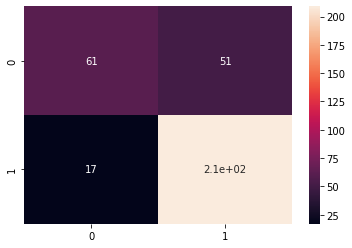

In [171]:
# for eating events
import sklearn
cm = sklearn.metrics.confusion_matrix(y_test, y_pred, labels=classifier1.classes_)
# true Write data values in each cell of the matrix
sns.heatmap(cm,annot=True)
plt.savefig('confusion.png')

from sklearn.metrics import classification_report
# printing the report
print(classification_report(y_test, y_pred))


In [172]:
classifier2 = RandomForestClassifier(n_estimators = 300)
classifier2.fit(X_train ,y_train)
y_pred = classifier2.predict(X_test)
y_pred1=eating_decision(y_pred)
y_test1=eating_decision(y_test)
print("accuracy for eating events =",accuracy_score(y_test,y_pred))
print("accuracy for eating decision =",accuracy_score(y_test1,y_pred1))
print("percenatge of the test dataset=",len(y_test)/(len(y_test)+len(y_train))*100,"%")



accuracy for eating events = 0.6153846153846154
accuracy for eating decision = 0.6521739130434783
percenatge of the test dataset= 38.89528193325661 %


In [173]:
y_pred

array([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1.

              precision    recall  f1-score   support

         0.0       0.30      0.12      0.18       112
         1.0       0.66      0.86      0.75       226

    accuracy                           0.62       338
   macro avg       0.48      0.49      0.46       338
weighted avg       0.55      0.62      0.56       338



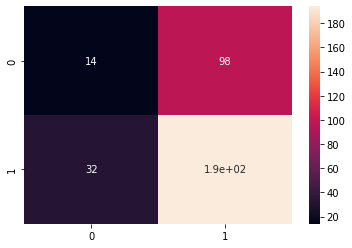

In [174]:
# for eating events
#y_pred = [1.,1.,1.,0.,1.,1.,1.,1.,0.,1.,1.]
import sklearn
cm = sklearn.metrics.confusion_matrix(y_test, y_pred, labels=classifier2.classes_)
# true Write data values in each cell of the matrix
sns.heatmap(cm,annot=True)
plt.savefig('confusion.png')
from sklearn import metrics
print(sklearn.metrics.classification_report(y_test, y_pred))




In [175]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
from sklearn.metrics import accuracy_score
y_pred1=eating_decision(y_pred)
y_test1=eating_decision(y_test)
print("accuracy for eating events =",accuracy_score(y_test,y_pred))
print("accuracy for eating decision =",accuracy_score(y_test1,y_pred1))
print("percenatge of the test dataset=",len(y_test)/(len(y_test)+len(y_train))*100,"%")



accuracy for eating events = 0.6568047337278107
accuracy for eating decision = 0.6956521739130435
percenatge of the test dataset= 38.89528193325661 %


In [176]:
y_pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1.

              precision    recall  f1-score   support

         0.0       0.41      0.08      0.13       112
         1.0       0.67      0.94      0.79       226

    accuracy                           0.66       338
   macro avg       0.54      0.51      0.46       338
weighted avg       0.59      0.66      0.57       338



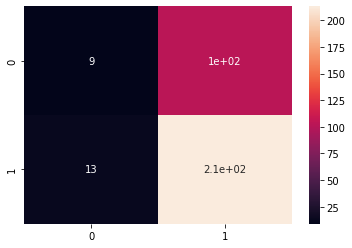

In [177]:

cm = sklearn.metrics.confusion_matrix(y_test, y_pred, labels=classifier.classes_)
# true Write data values in each cell of the matrix
sns.heatmap(cm,annot=True)
plt.savefig('confusion.png')

from sklearn.metrics import classification_report
# printing the report
print(classification_report(y_test, y_pred))

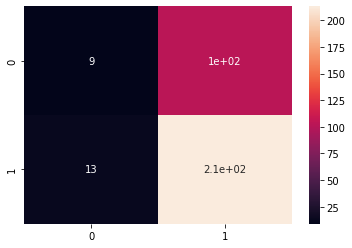

In [178]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred, labels=classifier1.classes_)
# true Write data values in each cell of the matrix
sns.heatmap(cm,annot=True)
plt.savefig('confusion.png')

In [179]:

from sklearn.metrics import classification_report
# printing the report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.41      0.08      0.13       112
         1.0       0.67      0.94      0.79       226

    accuracy                           0.66       338
   macro avg       0.54      0.51      0.46       338
weighted avg       0.59      0.66      0.57       338

